corr of SHARPR score and dragoNN ConvModel:
0.30578079430961147
corr of SHARPR score and gkmSVMModel:
0.15199604322567842
corr of SHARPR score and dragoNN DeepFactorizedModel:
0.2890440892770149
corr of SHARPR score and 6merModel:
0.5465201520524064


array([ 0.64745085, -0.62183184,  0.57290184,  0.8952065 ])

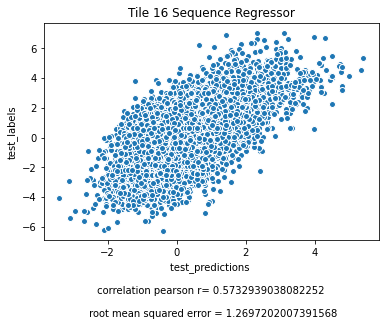

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
import joblib
import sys

#def sequence_file(tile_num):
tile_num = '15'
#create datapaths 
Data_path = "/u/home/m/mardren/scratch/SequenceML"
gkm_path = "%s/features.gkSVM.HepG2.tsv.gz"%Data_path
conv_path       = "%s/features.dragoNN_ConvModel.HepG2.SV40P.Rep1.tsv.gz"%Data_path
deepfact_path       = "%s/features.dragoNN_DeepFactorizedModel.HepG2.minP.Rep1.tsv.gz"%Data_path
tile_num_to_get_files = int(tile_num)
tile_num_to_get_files = tile_num_to_get_files + 1
kmer_path = "%s/6mer_prediction_tile%s.pkl"%(Data_path,tile_num_to_get_files)
sharpr_path = "%s/6mer_sharpr_score_tile%s.pkl"%(Data_path,tile_num_to_get_files)


#open data from csv into dataframes
gkm = pd.read_csv(gkm_path, header = 0, index_col = 0, sep = '\t')
conv  = pd.read_csv(conv_path, header = 0, index_col = 0, sep = '\t')
deepfact = pd.read_csv(deepfact_path, header = 0, index_col = 0, sep = '\t')
kmer = pd.read_pickle('%s'%(kmer_path))
#subset by selected tile
sharpr = pd.read_pickle('%s'%(sharpr_path))
gkm_15 = gkm[['feat_gksvm_%s'%tile_num]]
gkm_15 = gkm_15.rename(columns = {'feat_gksvm_%s'%tile_num:'gkm_%s'%tile_num})
conv_15 = conv[[tile_num]]
conv_15 = conv_15.rename(columns = {tile_num:'conv_%s'%tile_num})
deepfact_15 = deepfact[[tile_num]]
deepfact_15 = deepfact_15.rename(columns = {tile_num:'deepfact_%s'%tile_num})
tile_num = int(tile_num)
kmer_15 = kmer[[tile_num]]
kmer_15 = kmer_15.rename(columns = {tile_num:'kmer_%s'%tile_num})
sharpr_15 = sharpr[[tile_num]]
sharpr_15 = sharpr_15.rename(columns = {tile_num:'sharpr_%s'%tile_num})

#create data dataframe
data = pd.concat([conv_15, gkm_15, deepfact_15, kmer_15, sharpr_15], axis=1)

#check correlation
sharpr_15_array = np.asarray(sharpr_15)
sharpr_15_array = sharpr_15_array.flatten()
conv_15_array = np.asarray(conv_15)
conv_15_array = conv_15_array.flatten()
deepfact_15_array = np.asarray(deepfact_15)
deepfact_15_array = deepfact_15_array.flatten()
kmer_15_array = np.asarray(kmer_15)
kmer_15_array = kmer_15_array.flatten()
gkm_15_array = np.asarray(gkm_15)
gkm_15_array = gkm_15_array.flatten()
print('corr of SHARPR score and dragoNN ConvModel:')
print(pd.Series(sharpr_15_array).corr(pd.Series(conv_15_array)))
print('corr of SHARPR score and gkmSVMModel:')
print(pd.Series(sharpr_15_array).corr(pd.Series(gkm_15_array)))
print('corr of SHARPR score and dragoNN DeepFactorizedModel:')
print(pd.Series(sharpr_15_array).corr(pd.Series(deepfact_15_array)))
print('corr of SHARPR score and 6merModel:')
print(pd.Series(sharpr_15_array).corr(pd.Series(kmer_15_array)))


#reset index to be able to access region_id
data = data.reset_index()

#split region_id to create chrom column
data['chrom'] = data['region_id'].str.split('_').str[3]

#setting aside chr21 for testing data
test_set = data[data["chrom"] == 'chr21']
#removing chr21 from training data
train_set = data[data["chrom"] != 'chr21']
#dropping the chrom column
test_set = test_set.drop(columns=['chrom'])
train_set = train_set.drop(columns=['chrom'])
data = data.drop(columns=['chrom'])

#format training data
labels = train_set['sharpr_%s'%tile_num].values
train_set = train_set.drop(columns=['region_id','sharpr_%s'%tile_num])
encodings = train_set.values.tolist()
encodings = np.asarray(encodings)
encodings_df = pd.DataFrame(encodings)
encodings_df.fillna(encodings_df.mean(), inplace=True)
encodings = encodings_df.to_numpy()
labels = np.reshape(labels,(15537,))

#format the testing data
test_labels = test_set['sharpr_%s'%tile_num].values
test_set = test_set.drop(columns=['region_id','sharpr_%s'%tile_num])
test_encodings = test_set.values.tolist()
test_encodings = np.asarray(test_encodings)
test_encodings_df = pd.DataFrame(test_encodings)
test_encodings_df.fillna(test_encodings_df.mean(), inplace=True)
test_encodings = test_encodings_df.to_numpy()
test_labels = np.reshape(test_labels,(183,))
   #format training data
data_labels = data['sharpr_%s'%tile_num].values
data = data.drop(columns=['region_id','sharpr_%s'%tile_num])
data_encodings = data.values.tolist()
data_encodings = np.asarray(data_encodings)
data_encodings_df = pd.DataFrame(data_encodings)
data_encodings_df.fillna(data_encodings_df.mean(), inplace=True)
data_encodings = data_encodings_df.to_numpy()
data_labels = np.reshape(data_labels,(15720,))

#train a linear regressor on the training dataset. 
from sklearn.linear_model import LinearRegression

sequence_regressor = LinearRegression()
sequence_regressor.fit(encodings, labels)

#compute mse
#     from sklearn.metrics import mean_squared_error
#     test_predictions = sequence_regressor.predict(test_encodings)
#     test_mse = mean_squared_error(predictions, data_labels)
#     test_rmse = np.sqrt(test_mse)
from sklearn.metrics import mean_squared_error
predictions = sequence_regressor.predict(data_encodings)
mse = mean_squared_error(predictions, data_labels)
rmse = np.sqrt(mse)

data_encodings=data_encodings.flatten()
data__labels=data_labels.flatten()
#visualize the results
corr = pd.Series(predictions).corr(pd.Series(data_labels))

caption = "correlation pearson r= %s"%(corr)
rmse = "root mean squared error = %s"%rmse


plt.scatter(
    x=predictions,
    y=data_labels,
    edgecolors='w'
)
tile_num = int(tile_num)
tile_num = tile_num + 1

plt.title("Tile %s Sequence Regressor"%(tile_num))
plt.xlabel("test_predictions \n\n %s \n\n %s"%(caption,rmse))
plt.ylabel("test_labels")

plt.savefig("sequence_predictions_tile%s"%tile_num)

sequence_regressor.coef_

#     fn = open("sequence_predictions_tile%s.txt"%tile_num,"w")
#     np.savetxt(fn,predictions)
#     fn.close()

    

# if __name__ == "__main__":
#     # take tile_num in as a parameter
#     tile_num = '0'
#     sequence_file(tile_num)

    
    
#     tiles = list(range(1, 31))
#      plt.plot(
#         tiles,
#         corr
#     )

#     plt.title("Correlation by Tile")
#     plt.xlabel("tile")
#     plt.ylabel("correlation")

#     plt.show("sequence_predictions_tile")

In [3]:
sequence_regressor.coef_

NameError: name 'sequence_regressor' is not defined

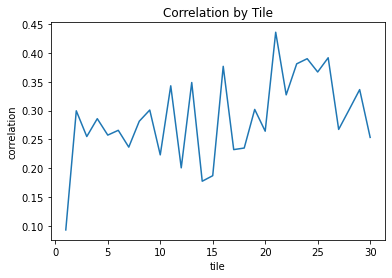

In [48]:
    plt.plot(
        tiles,
        corr
    )

    plt.title("Correlation by Tile")
    plt.xlabel("tile")
    plt.ylabel("correlation")

    plt.show("sequence_predictions_tile")

In [137]:
#reset index to be able to access region_id
data = data.reset_index()

#split region_id to create chrom column
data['chrom'] = data['region_id'].str.split('_').str[3]

#setting aside chr21 for testing data
test_set = data[data["chrom"] == 'chr21']
#removing chr21 from training data
train_set = data[data["chrom"] != 'chr21']
#dropping the chrom column
test_set = test_set.drop(columns=['chrom'])
train_set = train_set.drop(columns=['chrom'])

    



In [138]:
test_set

,region_id,conv_7,gkm_7,deepfact_7,kmer_7,sharpr_7
6,H1hesc_10_15_chr21_47716435,-0.032599,0.243042,-0.178223,0.420126,-0.631780
11,H1hesc_10_1_chr21_46531055,-0.003406,0.150939,0.057762,0.384609,1.130439
15,H1hesc_10_23_chr21_44710495,-0.125071,0.165631,-0.288532,0.542107,0.942199
17,H1hesc_10_25_chr21_38359515,0.060908,0.224397,0.275996,0.470891,1.798465
35,H1hesc_10_5_chr21_15448955,0.276386,0.225293,0.412858,0.870475,1.038430
...,...,...,...,...,...,...
15415,K562_9_186_chr21_39404935,-0.095704,0.054674,0.008857,-0.017392,1.276589
15436,K562_9_204_chr21_25889795,-0.342562,0.126727,0.753136,-0.095566,-1.666827
15517,K562_9_278_chr21_15091595,0.299530,0.189318,0.146289,0.809912,0.425619
15573,K562_9_328_chr21_39601535,0.038474,0.233018,-0.204695,1.214277,0.485176


In [139]:
labels = train_set['sharpr_%s'%tile_num].values

In [140]:
train_set = train_set.drop(columns=['region_id','sharpr_%s'%tile_num])
encodings = train_set.values.tolist()
encodings = np.asarray(encodings)
encodings_df = pd.DataFrame(encodings)
encodings_df.fillna(encodings_df.mean(), inplace=True)
encodings = encodings_df.to_numpy()
labels = np.reshape(labels,(15537,))

In [141]:

#test_set.to_pickle('%s/%s_test_set.pkl'%(Data_path, tile_num)

#format the training data
#labels = train_set['sharpr_15'].values
# train_set = train_set.drop(columns=['region_id','sharpr_15'])
# encodings = train_set.values.tolist()
# encodings = np.asarray(encodings)
# encodings_df = pd.DataFrame(encodings)
# encodings_df.fillna(encodings_df.mean(), inplace=True)
# encodings = encodings_df.to_numpy()
# labels = np.reshape(labels,(12888,))


#format the testing data
test_labels = test_set['sharpr_%s'%tile_num].values
test_set = test_set.drop(columns=['region_id','sharpr_%s'%tile_num])
test_encodings = test_set.values.tolist()
test_encodings = np.asarray(test_encodings)
test_encodings_df = pd.DataFrame(test_encodings)
test_encodings_df.fillna(test_encodings_df.mean(), inplace=True)
test_encodings = test_encodings_df.to_numpy()
test_labels = np.reshape(test_labels,(183,))


In [142]:
#train a linear regressor on the training dataset. 
from sklearn.linear_model import LinearRegression

sequence_regressor = LinearRegression()
sequence_regressor.fit(encodings, labels)

LinearRegression()

In [143]:
encodings

array([[-0.17318532,  0.07174177, -0.3193351 ,  0.46704546],
       [ 0.0108388 ,  0.029652  , -0.18368907, -0.35987881],
       [ 0.03997922,  0.06603316,  0.3280099 , -0.39431267],
       ...,
       [-0.21446411,  0.03362841,  0.18228859, -0.21206448],
       [ 0.5510333 ,  0.0782281 , -0.04327216,  0.24012516],
       [-0.28694302, -0.05472399, -0.01872583, -0.4236812 ]])

In [144]:
test_encodings

array([[-3.25992850e-02,  2.43041511e-01, -1.78222940e-01,
         4.20126321e-01],
       [-3.40620240e-03,  1.50938637e-01,  5.77616100e-02,
         3.84609314e-01],
       [-1.25070530e-01,  1.65631444e-01, -2.88532440e-01,
         5.42106896e-01],
       [ 6.09082730e-02,  2.24396704e-01,  2.75995700e-01,
         4.70891413e-01],
       [ 2.76386470e-01,  2.25293096e-01,  4.12858000e-01,
         8.70475180e-01],
       [ 9.75544100e-02,  1.16869393e-01,  7.99786600e-02,
         7.52784446e-01],
       [ 4.99038100e-02,  1.49640548e-01,  4.56504020e-01,
         1.73598552e-02],
       [-2.03374800e-01,  4.90187068e-02,  4.03085500e-01,
         2.74428156e-01],
       [ 5.40770800e-02,  2.10104542e-01,  2.91245460e-01,
         2.79540534e-01],
       [-2.00430120e-01,  9.84662222e-03, -2.47583940e-01,
         2.79645372e-01],
       [ 1.76685240e-01,  2.27254674e-01,  4.15353450e-01,
         7.99607205e-01],
       [ 8.49940700e-02,  1.63724452e-01, -5.38591800e-02,
      

In [145]:
test_encodings

array([[-3.25992850e-02,  2.43041511e-01, -1.78222940e-01,
         4.20126321e-01],
       [-3.40620240e-03,  1.50938637e-01,  5.77616100e-02,
         3.84609314e-01],
       [-1.25070530e-01,  1.65631444e-01, -2.88532440e-01,
         5.42106896e-01],
       [ 6.09082730e-02,  2.24396704e-01,  2.75995700e-01,
         4.70891413e-01],
       [ 2.76386470e-01,  2.25293096e-01,  4.12858000e-01,
         8.70475180e-01],
       [ 9.75544100e-02,  1.16869393e-01,  7.99786600e-02,
         7.52784446e-01],
       [ 4.99038100e-02,  1.49640548e-01,  4.56504020e-01,
         1.73598552e-02],
       [-2.03374800e-01,  4.90187068e-02,  4.03085500e-01,
         2.74428156e-01],
       [ 5.40770800e-02,  2.10104542e-01,  2.91245460e-01,
         2.79540534e-01],
       [-2.00430120e-01,  9.84662222e-03, -2.47583940e-01,
         2.79645372e-01],
       [ 1.76685240e-01,  2.27254674e-01,  4.15353450e-01,
         7.99607205e-01],
       [ 8.49940700e-02,  1.63724452e-01, -5.38591800e-02,
      

In [146]:
from sklearn.metrics import mean_squared_error
test_predictions = sequence_regressor.predict(test_encodings)
test_mse = mean_squared_error(test_predictions, test_labels)
test_rmse = np.sqrt(test_mse)

In [147]:
test_rmse

1.5112103194352628

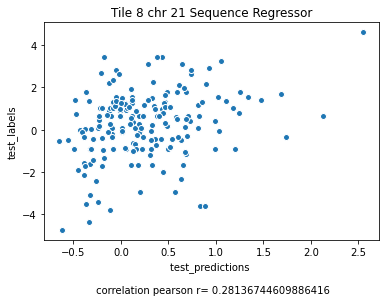

In [148]:
test_encodings=test_encodings.flatten()
test__labels=test_labels.flatten()
#visualize the results
caption = "correlation pearson r= %s"%(pd.Series(test_predictions).corr(pd.Series(test_labels)))


plt.scatter(
    x=test_predictions,
    y=test_labels,
    edgecolors='w'
)
tile_num = int(tile_num)
tile_num = tile_num + 1

plt.title("Tile %s chr 21 Sequence Regressor"%(tile_num))
plt.xlabel("test_predictions \n\n %s"%caption)
plt.ylabel("test_labels")

plt.show()

In [149]:
fn = open("sequence_predictions_tile%s.txt"%tile_num,"w")
np.savetxt(fn,test_predictions)
fn.close()

In [119]:
sequence_regressor.coef_

array([ 1.24793958, -0.26916741,  0.71630956,  0.58157011])